# [LAB-11] 3. 여러 변수의 상관분석

- 상관분석 flow:
1. 여러 변수(피쳐) 쌍을 교차해 상관을 살피고,
2. 가정 점검 결과에 따라 피어슨/스피어만을 선택

- correlation is not a cause-effect relationship!
  - 숨은변수, 매개변수 등 존재
  - p-value는 표본 크기의 영향을 크게 받으므로 시각화(heatmap)와 함께 해석 필요함

## #01. 준비작업

### 1. 패키지 가져오기:

In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

# 파이썬 기본 패키지:
from itertools import combinations

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기:

In [3]:
origin = load_data('mtcars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/mtcars.xlsx
[desc] 자동차 32종의 11개 속성에 대한 정보를 담고 있는 데이터 (출처: R 기본 데이터)

필드    타입      설명
------  --------  --------------------------------
name    str       차종 이름 (인덱스)
mpg     str       연료 효율성 (마일 당 갤런)
cyl     category  실린더 수
disp    float     배기량 (cubic inches)
hp      float     마력 (horsepower)
drat    float     후륜축 비율 (rear axle ratio)
wt      float     차량 무게 (1000 파운드)
qsec    float     1/4 마일 달성 시간 (초)
vs      category  엔진 유형 (0: V 엔진, 1: S 엔진)
am      category  변속기 형태 (0: 자동, 1: 수동)
gear    category  전진 기어 수 (전송 기어)
carb    category  기화기 개수 (carburetors)


===== 데이터 크기 확인 =====
데이터셋 크기: (32, 11)
열 갯수: 11
행 갯수: 32

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      3

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
name,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


### 4. 데이터 전처리:

명목형 변수 제외, 수치형 변수 컬럼들만 남기기:

∵ 상관분석은 수치형 변수만!

In [4]:
df = origin.filter(['mpg', 'disp', 'hp', 'drat', 'wt', 'qsec'])
df.head()

,mpg,disp,hp,drat,wt,qsec
name,,,,,,
Mazda RX4,21.0,160.0,110,3.90,2.620,16.46
Mazda RX4 Wag,21.0,160.0,110,3.90,2.875,17.02
Datsun 710,22.8,108.0,93,3.85,2.320,18.61
Hornet 4 Drive,21.4,258.0,110,3.08,3.215,19.44
Hornet Sportabout,18.7,360.0,175,3.15,3.440,17.02


## #02. 상관분석 가정 및 시각화

변수 3개 이상부터는 변수'쌍'을 '모두 교차'해 상관 봐야됨.

우선, 수치형 변수만 선택 후 왜도/이상치 여부 파악:
- 1. 선형성/단조성: 페어플롯으로 형태 파악, 필요시 변수별 분포 확인
- 2. 분포, 이상치: 왜도와 z-score(> |3|)로 왜곡 여부 확인

### 1. 선형성 (by pairplot):

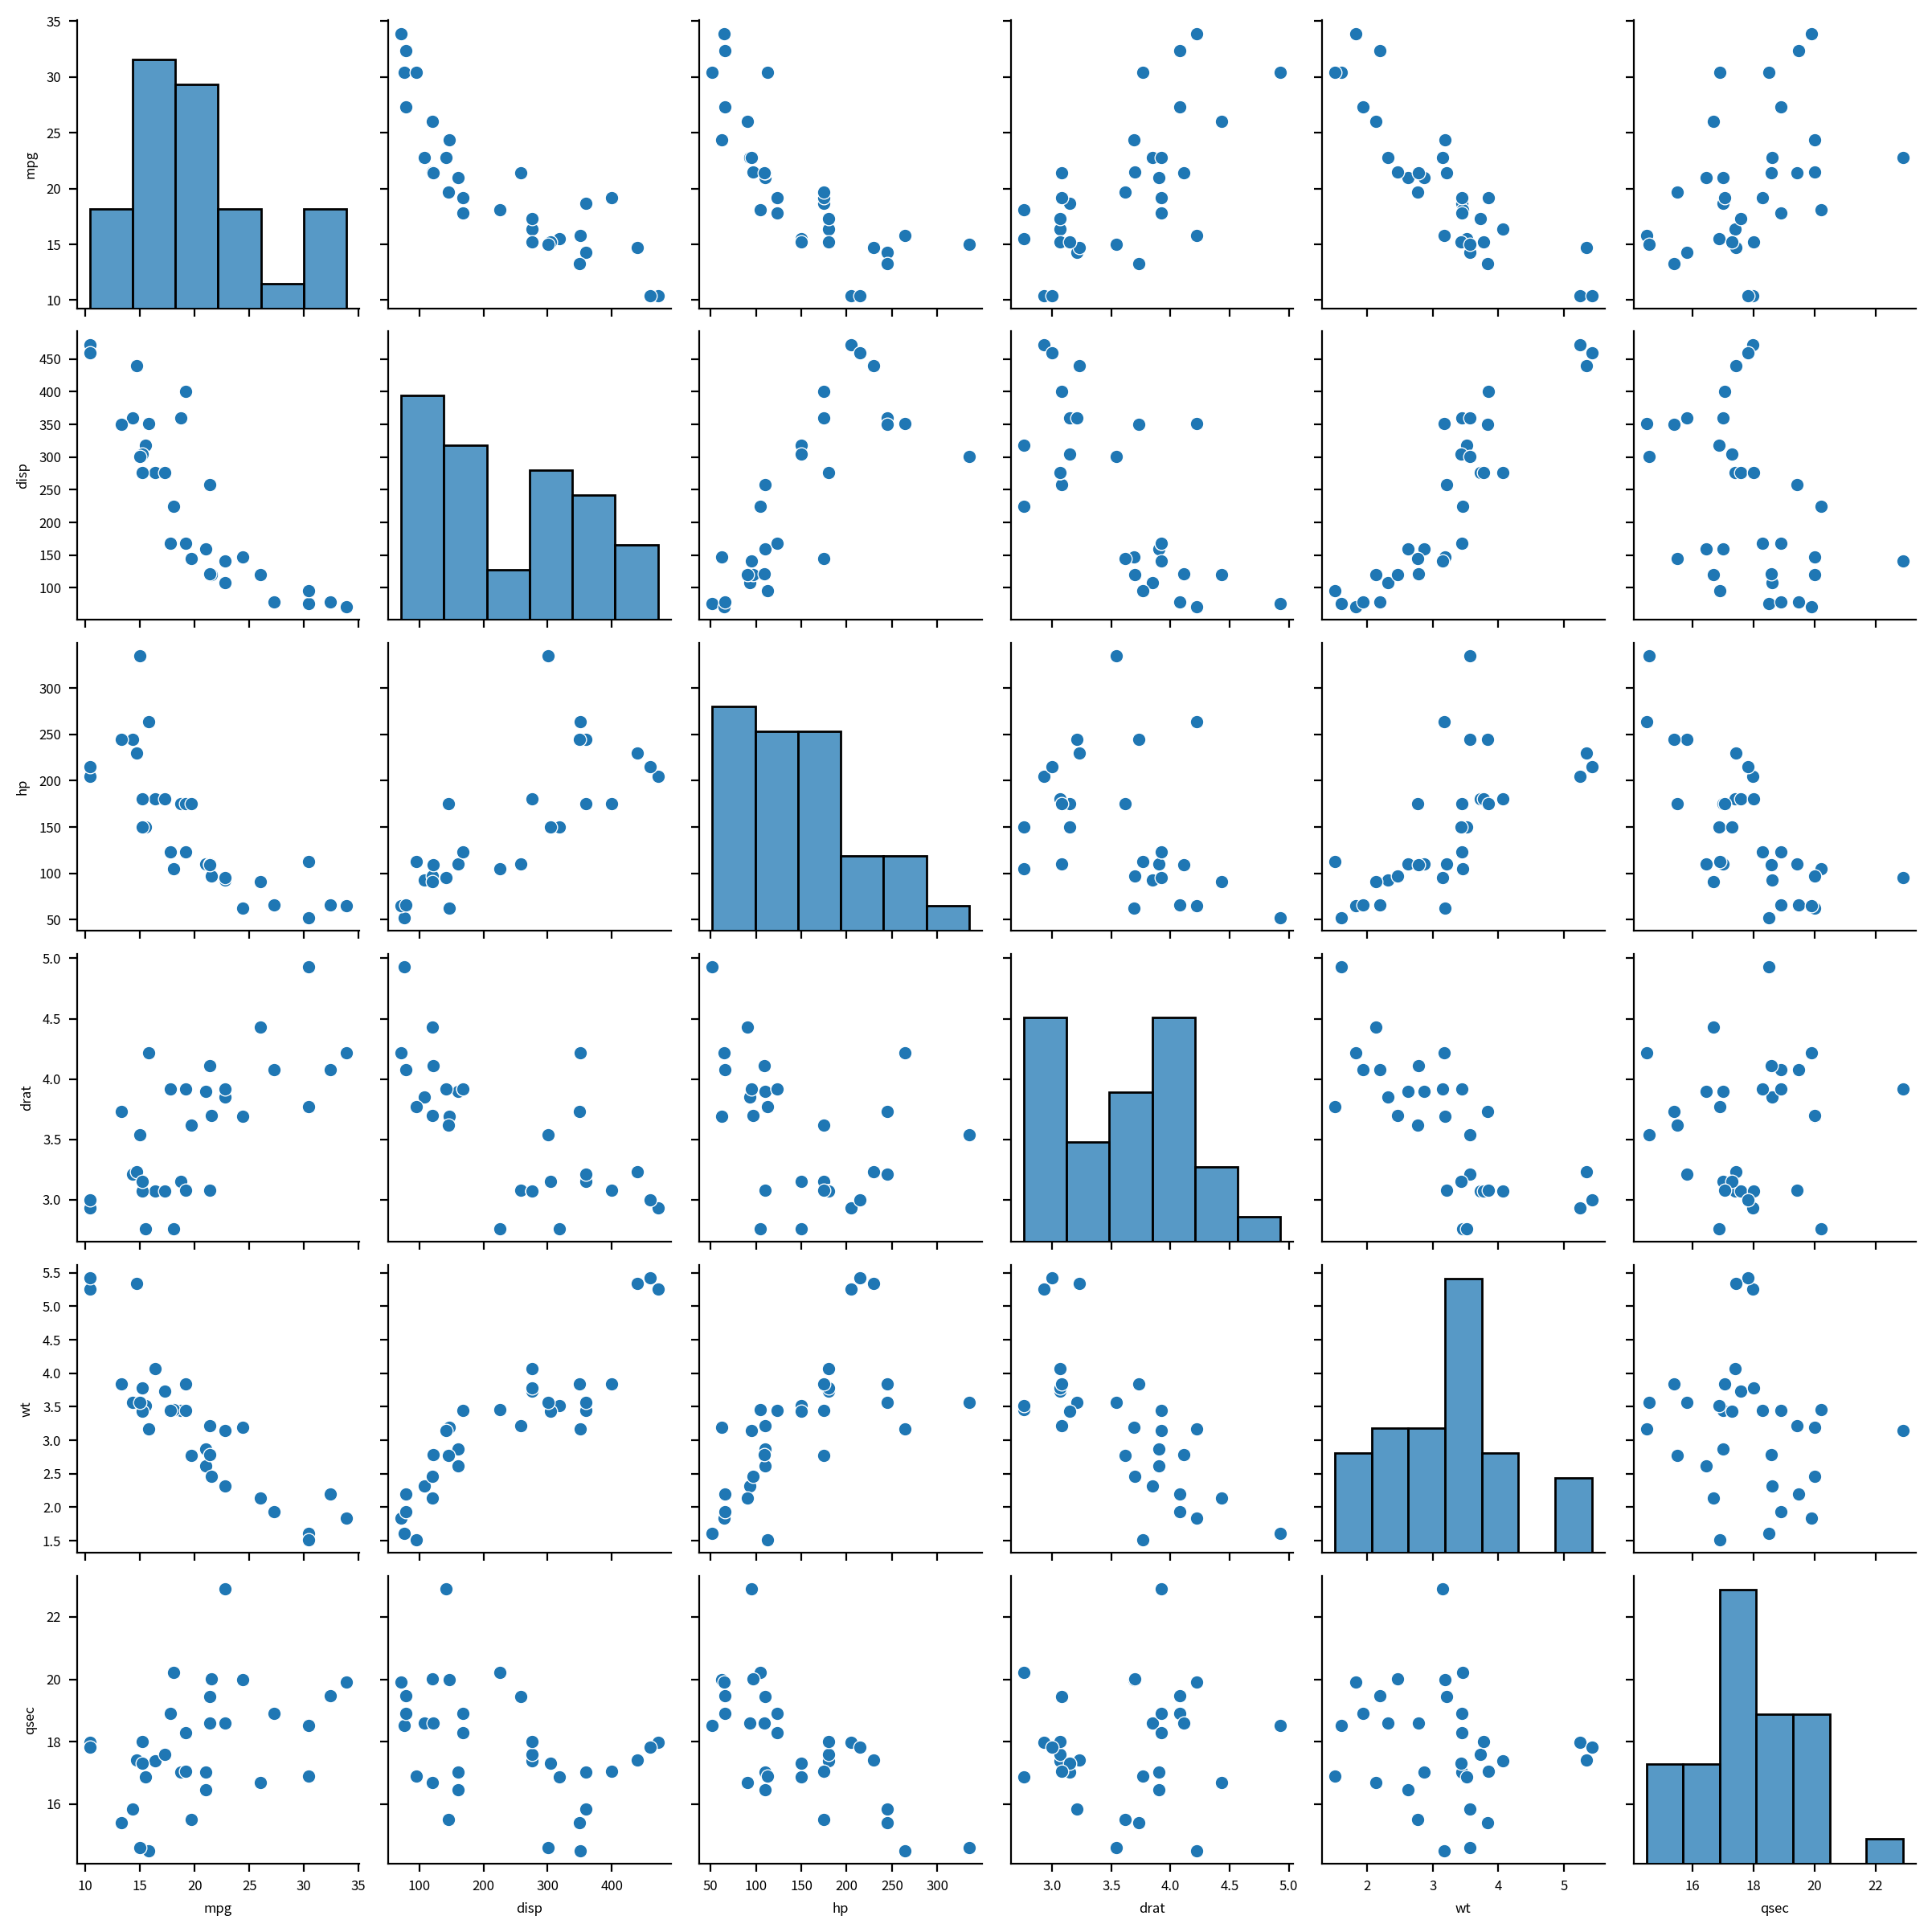

In [5]:
# 1) 그래프 초기화
width_px = 2400             # width_px = height_px
height_px = 2400             
figsize = (width_px / my_dpi, height_px / my_dpi)

# 2) Pair Plot 그래프 그리기
    # 'corner = True' 파라미터 추가 시 대각선 아래 subplot들만 표시된다
g = sb.pairplot(df, diag_kind='hist')
g.fig.set_dpi(my_dpi)
g.fig.set_size_inches(figsize)

# 3) 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프 화면 출력
plt.close()                 # 그래프 작업 종료

> 눈대중 확인이 어려움.

### 2. 이상치 요약:

이상치는 개별 컬럼단위로 판단할 수 있으므로 미리 처리해 둔다:

In [6]:
skew_outlier = {}

for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }

skew_outlier_df = pd.DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z| > 3)
mpg,0.672377,-0.960191,0.0
disp,0.420233,-1.292987,0.0
hp,0.799407,-1.466775,0.0
drat,0.292780,-0.044575,0.0
wt,0.465916,-0.298323,0.0
qsec,0.406347,-0.770281,0.0


## #03. 변수쌍 별 상관 검정 및 방법 선택

- 기준: 변수 중 하나라도 왜도 크거나/ 이상치 있거나/ 비선형 가능성 -> select 'Spearman' owtherwise 'Pearson'
- 'Spearman'과 'Pearson' 상관계수 모두 계산, 비교하며 선택된 상관계수들과 p-values 들을 요약 ㄱㄱ

### 1. 'intertools'의 "combinations"함수 기능 이용:

combinations(): 주어진 리스트(mylist)에서 r에 지정된 갯수 만큼 쌍으로 묶어 조합 가능한 모든 경우의 수를 생성.

In [7]:
# 예시:
mylist = [10, 20, 30]
my_comb = combinations(mylist, r = 2)

for c in my_comb:
    print(c)

(10, 20)
(10, 30)
(20, 30)


### 2. 상관분석 수행:

In [ ]:
rows = []

for a, b in combinations(df.columns, 2):
    x = df[a]
    y = df[b]

    # [1] 선형성 확인 (Ramsey RESET):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power = 2, use_f = True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부(|z| > 3 기준):
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산:
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)
    
    # [4] 유의성 판단 (p <= 0.05):
    significant = pval <= 0.05

    # [5] 상관강도 계산:
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    # [6] 행 추가:
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,mpg,disp,False,False,spearman,-0.908882,6.370336e-13,True,Very strong
1,mpg,hp,True,False,pearson,-0.776168,1.787835e-07,True,Strong
2,mpg,drat,True,False,pearson,0.681172,1.776240e-05,True,Strong
3,mpg,wt,False,False,spearman,-0.886422,1.487595e-11,True,Very strong
4,mpg,qsec,True,False,pearson,0.418684,1.708199e-02,True,Medium
5,disp,hp,True,False,pearson,0.790949,7.142679e-08,True,Strong
6,disp,drat,False,False,spearman,-0.683592,1.613884e-05,True,Strong
7,disp,wt,True,False,pearson,0.887980,1.222320e-11,True,Very strong
8,disp,qsec,True,False,pearson,-0.433698,1.314404e-02,True,Medium
9,hp,drat,False,False,spearman,-0.520125,2.277988e-03,True,Medium


### 3. 결과 시각화

#### 1) 상관행렬 생성:

In [9]:
# 1) 등장하는 모든 변수 목록 추출:
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))
             # ↑: 중복 제거하고 추출

# 2) 빈 상관행렬 생성 (NaN으로 초기화):
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭행렬 채우기:
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r   # 대칭 

# 4) 대각선(diagonal)을 1로 설정:
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,disp,drat,hp,mpg,qsec,wt
disp,1.000000,-0.683592,0.790949,-0.908882,-0.433698,0.887980
drat,-0.683592,1.000000,-0.520125,0.681172,0.091205,-0.712441
hp,0.790949,-0.520125,1.000000,-0.776168,-0.708223,0.774677
mpg,-0.908882,0.681172,-0.776168,1.000000,0.418684,-0.886422
qsec,-0.433698,0.091205,-0.708223,0.418684,1.000000,-0.174716
wt,0.887980,-0.712441,0.774677,-0.886422,-0.174716,1.000000


#### 2) 상관행렬 시각화 (히트맵):

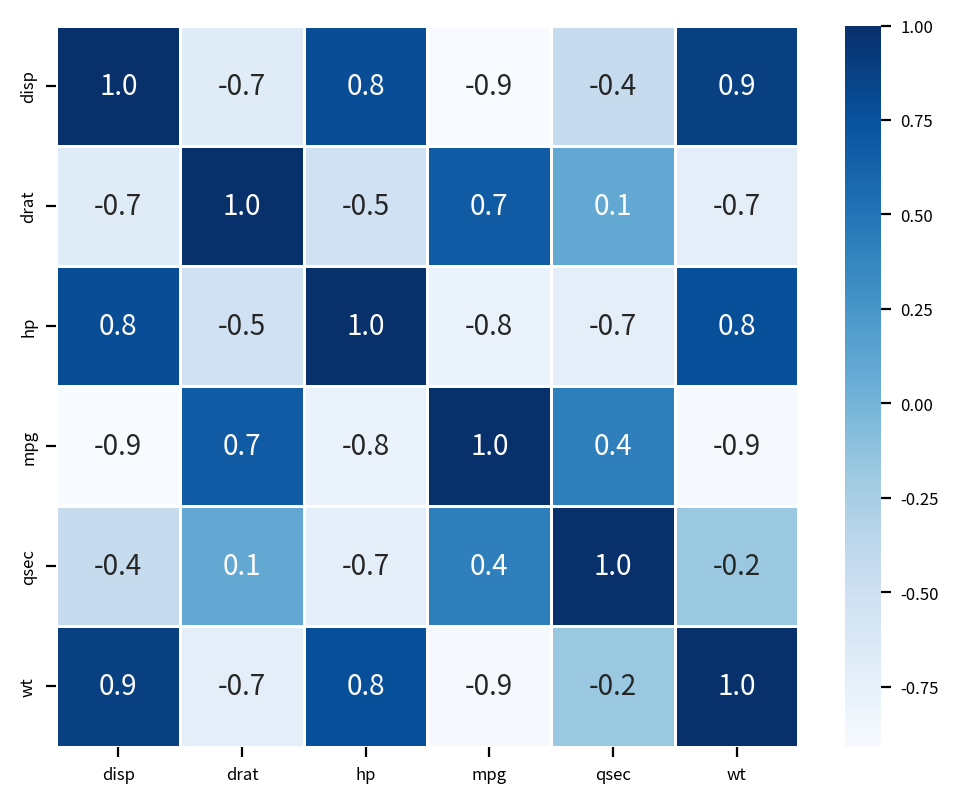

In [10]:
# 1) 그래프 초기화
width_px = 1000             # 가로 = 세로 맞추기
height_px = 800            
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)


# 2) Heatmap 그리기: 
sb.heatmap(data = corr_matrix, annot=True, fmt='0.1f', 
           linewidth = 0.5, cmap = "Blues", 
           annot_kws = {'size': 10})
  # camp: 칼라맵 
    # 종류: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds' / 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu' / 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn' / 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu' / 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic' / 'berlin', 'managua', 'vanimo'

# 4) 출력
plt.savefig('plot.png', dpi = my_dpi * 2)   # 이미지파일 저장                              # 배경 격자 표시/숨김 (테마별로 다름)
plt.tight_layout()                          # 여백 제거
plt.show()                                  # 그래프 화면 출력
plt.close()                                 # 그래프 작업 종료

## #04. 인사이트

본 연구에서는 주요 연속형 변수들 간의 상관구조를 파악하기 위해, 선형성 및 이상치 여부를 사전 점검한 후 피어슨 또는 스피어만 상관계수를 선택적으로 적용하였다. 분석 결과는 다음과 같
다.

**1. mpg 관련 변수들**

mpg–disp의 경우 비선형성이 관찰되어 스피어만 상관계수를 적용한
결과 매우 강한 음의 단조관계(ρ = −0.9089, p < 0.001)가 나타났다. mpg–hp와 mpg–drat에서는 선형성이 충족되어 피어슨 상관계수를 사용하였고, 각각 강한 음의(r = −0.7762, p < 0.001) 및 강한 양의(r = 0.6812, p < 0.001) 상관이 확인되었다. mpg–wt는 비선형성이 확인되어 스피어만 상관계수를 적용하였으며 매우 강한 음의 관계(ρ = −0.8864, p < 0.001)가 나타났다. mpg–
qsec은 중간 수준의 양의 상관(r = 0.4187, p = 0.017)이 통계적으로 유의하였다.

**2. disp 관련 변수들**

disp–hp와 disp–wt에서는 선형성이 충족되어 피어슨 상관계수를 적용하였으며 각각 강한(r = 0.7909, p < 0.001) 및 매우 강한(r = 0.88798, p < 0.001) 양의 상관이 확인되었다. 반면 disp–drat은 비선형성이 관찰되어 스피어만 상관계수를 사용하였고 강한 음의 단조 관계(ρ = −0.6836, p < 0.001)가 나타났다. disp–qsec에서는 중간 수준의 음의 상관(r = −0.4337, p = 0.013 이 통계적으로 유의하였다.

**3. hp 관련 변수들**

hp–drat과 hp–wt에서는 비선형성이 확인되어 스피어만 상관계수를 적용하였으며 각각 중간 수준의 음의(ρ = −0.5201, p = 0.002) 및 강한 양의(ρ = 0.7747, p < 0.001) 단조 관계가 나타났다. hp–qsec은 피어슨 상관계수를 적용한 결과 강한 음의 상관(r = −0 7082, p < 0.001)이 확인되었다.

**4. drat 및 wt 관련 상관**

drat–wt에서는 선형성이 충족되어 피어슨 상관계수를 사용하였고 강한 음의 상관(r = −0.7124, p < 0.001)이 나타났다. drat–qsec은 매우 약한 양의 상관(r = 0.0912, p = 0.620)으로 통계적으로 유의하지 않았으며, wt–qsec 역시 매우 약한 음의 상 (r = −0.1747, p = 0.339)으로 유의하지 않았다.

**종합 논의**

분석 결과, mpg는 disp 및 wt와 매우 강한 음의 관계를 보였으며 hp 및 drat과도 강한 수준의 상관을 나타내 차량 연비와 기계적 특성 간의 밀접한 연관성을 확인할 수 있었다. disp는 wt 및 hp와 강한 양의 관계를 보여 엔진 배기량이 차량 중량 및 출력과 구조적으로 연계되어 있음을 시사한다. 반면 drat–qsec 및 wt–qsec 조합에서는 유의한 상관이 나타나지 않아 변수 간 직접적 연관성이 약함을 보여주었다. 본 분석은 선형성 및 이상치 여부를 고려하여 적절한 상관계수를 선택하였으며, 이는 상관해석의 신뢰성을 높이는 데 기여하였다. 이러한 결과는 후속 회귀분석 또는 예측 모델 구축에서 변수 선택의 중요한 근거로 활용될 수 있다.